In [53]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

# !pip install matplotlib pandas
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
import seaborn as sns



ModuleNotFoundError: No module named 'torch'

Australia
New South Wales
Northern Territory
Queensland
South Australia
Tasmania
Victoria
Western Australia


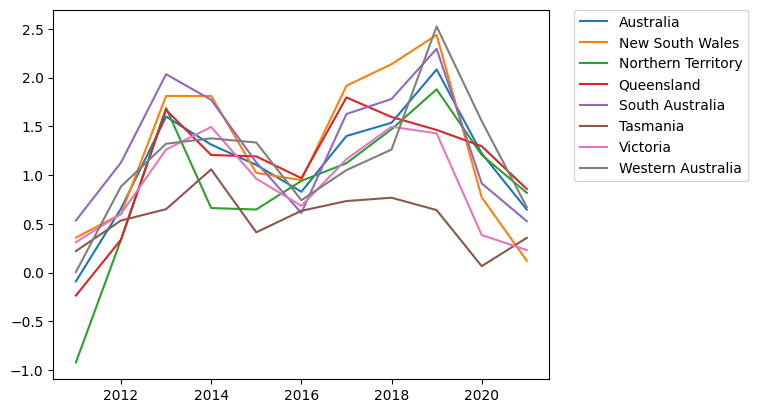

In [207]:
enviro_csv = dict( temp='Enviromental/temp_max_anomaly_c.csv', rainfall='Enviromental/total_rainfall_mm.csv', water_trades= 'Enviromental/water_trades_2011_2021.csv',water_usage= 'Enviromental/water_usage_region_year.csv')



In [ ]:

df.index.unique()# Index(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020' ,2011], dtype='object', name='Year')


Australia
New South Wales
Northern Territory
Queensland
South Australia
Tasmania
Victoria
Western Australia


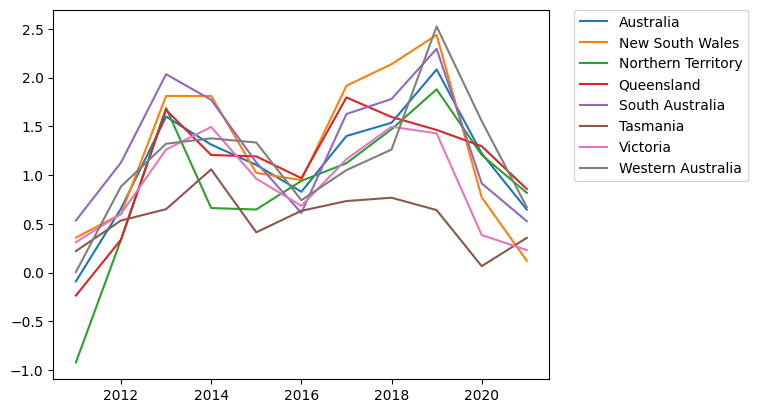

In [102]:
# https://drive.google.com/drive/folders/1Q1qfIj1odObfNIb6dPI8sTzVJ02fveno
# There are two folders with csv datasets in them (Environmental and Governance)
#
import pandas as pd
df = pd.read_csv('Enviromental/water_trades_2011_2021.csv', header = 0).dropna()

df


,resource_type,origin_state,origin_water_system,origin_trading_zone_or_WRPA,dest_state,dest_water_system,dest_trading_zone_or_WRPA,unit_of_measure,quantity_traded,net_price,price_per_ML,date_of_approval,regulated_unregulated,drainage_division,murray_darling_basin_region
1,Groundwater,New South Wales,Lachlan Alluvium (GW10),Lower Lachlan Groundwater Source,New South Wales,Lachlan Alluvium (GW10),Lower Lachlan Groundwater Source,ML,300.0,0,0.0,27-05-2019,unregulated,Murray–Darling Basin,MDB Groundwater
2,Groundwater,New South Wales,Lachlan Alluvium (GW10),Upper Lachlan Alluvial Groundwater Source / Up...,New South Wales,Lachlan Alluvium (GW10),Upper Lachlan Alluvial Groundwater Source / Up...,ML,240.0,0,0.0,27-05-2019,unregulated,Murray–Darling Basin,MDB Groundwater
3,Groundwater,New South Wales,Murray Alluvium (GW8),Lower Murray Groundwater Source,New South Wales,Murray Alluvium (GW8),Lower Murray Groundwater Source,ML,45.0,45,1.0,24-05-2019,unregulated,Murray–Darling Basin,MDB Groundwater
4,Groundwater,New South Wales,Murray Alluvium (GW8),Lower Murray Groundwater Source,New South Wales,Murray Alluvium (GW8),Lower Murray Groundwater Source,ML,7.7,0,0.0,27-05-2019,unregulated,Murray–Darling Basin,MDB Groundwater
5,Groundwater,New South Wales,Murray Alluvium (GW8),Lower Murray Groundwater Source,New South Wales,Murray Alluvium (GW8),Lower Murray Groundwater Source,ML,10.3,0,0.0,27-05-2019,unregulated,Murray–Darling Basin,MDB Groundwater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34298,Surface water,Victoria,VIC Murray (SS2),6 VIC Murray - Dart to Barmah,Victoria,VIC Murray (SS2),7 VIC Murray - Barmah to SA,ML,2.2,0,0.0,27-10-2019,regulated,Murray–Darling Basin,Southern MDB
34299,Surface water,Victoria,VIC Murray (SS2),6 VIC Murray - Dart to Barmah,Victoria,VIC Murray (SS2),7 VIC Murray - Barmah to SA,ML,2.5,0,0.0,27-10-2019,regulated,Murray–Darling Basin,Southern MDB
34300,Surface water,Victoria,VIC Murray (SS2),6 VIC Murray - Dart to Barmah,Victoria,VIC Murray (SS2),7 VIC Murray - Barmah to SA,ML,5.0,0,0.0,27-10-2019,regulated,Murray–Darling Basin,Southern MDB
34301,Surface water,Victoria,VIC Murray (SS2),6 VIC Murray - Dart to Barmah,Victoria,VIC Murray (SS2),7 VIC Murray - Barmah to SA,ML,5.0,0,0.0,27-10-2019,regulated,Murray–Darling Basin,Southern MDB


In [101]:

df = pd.read_csv('Enviromental/water_usage_region_year.csv', header = 1).dropna()
df.iloc[1:]


,Commodity description,Unnamed: 1,Area of holding - Total area (ha) (a),"Water source - Groundwater (e.g. bores, springs, wells) - Total volume used (ML)",Water source - Total volume of water from all sources (ML) (b),Water source - Water taken from on-farm dams or tanks - Total volume used (ML),"Water source - Water taken from rivers, creeks, lakes, etc. - Total volume used (ML)",Water use - Total application rate (ML/ha),Water use - Total area watered (ha),Water use - Total volume applied (ML),Area of holding - Total area (ha) (a).1,"Water source - Groundwater (e.g. bores, springs, wells) - Total volume used (ML).1",Water source - Total volume of water from all sources (ML) (b).1,Water source - Water taken from on-farm dams or tanks - Total volume used (ML).1,"Water source - Water taken from rivers, creeks, lakes, etc. - Total volume used (ML).1",Water use - Total application rate (ML/ha).1,Water use - Total area watered (ha).1,Water use - Total volume applied (ML).1
5,Adelaide - Central and Hills,2013,55944.21,11596.94,20319.02,6748.18,1136.24,2.85,6716.88,19127.68,894.0,497.0,797.0,488.0,110.0,0.0,450.0,450.0
6,Adelaide - Central and Hills,2014,59636.80,13257.00,25435.88,8926.66,2575.09,3.44,6886.61,23690.30,784.0,557.0,767.0,448.0,116.0,0.0,478.0,478.0
7,Adelaide - Central and Hills,2015,84277.59,11653.42,16342.25,2779.75,814.13,3.23,4710.60,15202.21,415.0,281.0,401.0,203.0,61.0,0.0,260.0,260.0
8,Adelaide - Central and Hills,2016,45380.13,10159.41,14530.29,3364.41,403.28,2.59,5200.12,13482.05,434.0,298.0,408.0,237.0,25.0,0.0,279.0,279.0
9,Adelaide - Central and Hills,2017,45611.51,8147.99,13020.27,2937.24,898.57,3.43,3490.89,11980.27,365.0,231.0,339.0,183.0,19.0,0.0,229.0,229.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998,Yarramundi - Londonderry,2020,1734.53,1.40,929.90,21.46,896.07,7.81,119.01,929.90,30.0,1.0,13.0,7.0,5.0,0.0,13.0,13.0
2002,Yass Surrounds,2020,353092.49,257.36,1429.32,266.97,904.99,2.56,564.69,1446.26,483.0,23.0,35.0,16.0,5.0,0.0,35.0,35.0
2003,Yea,2020,91341.80,318.11,2905.90,550.93,732.95,1.71,1698.11,2903.55,145.0,4.0,21.0,12.0,7.0,0.0,21.0,21.0
2009,Young,2020,49142.32,497.10,707.18,186.12,23.23,0.76,964.86,737.25,101.0,19.0,21.0,5.0,1.0,0.0,21.0,21.0


In [274]:
#Governance/agriculture_australian_economy.csv
# !cd Governance && ls

# agriculture_australian_economy.csv  cpi_consumer_price_index.csv
# commodity_production_value.csv	    employment.csv
gov = dict(economy="Governance/agriculture_australian_economy.csv", cpi="Governance/cpi_consumer_price_index.csv", commodity ="Governance/commodity_production_value.csv",employment= "Governance/employment.csv")


MultiIndex([(                        'Product', 'Unit'),
            (                         'Barley',   '$m'),
            (                          'Maize',   '$m'),
            (                        'Sorghum',   '$m'),
            (                           'Oats',   '$m'),
            (                           'Rice',   '$m'),
            (                      'Triticale',   '$m'),
            (                          'Wheat',   '$m'),
            (            'Other cereal grains',   '$m'),
            (                         'Canola',   '$m'),
            (                       'Soybeans',   '$m'),
            (                 'Sunflower Seed',   '$m'),
            (                 'Oilseeds other',   '$m'),
            (                      'Chickpeas',   '$m'),
            (                     'Field peas',   '$m'),
            (                         'Lupins',   '$m'),
            (                  'Other legumes',   '$m'),
            (    'Grains, oilse

,Product,Barley,Maize,Sorghum,Oats,Rice,Triticale,Wheat,Other cereal grains,Canola,...,Other horticulture,Horticulture total,Sundry crops,Total crops,Cattle slaughtered,Sheep slaughtered,Lambs slaughtered,Pigs slaughtered,Poultry slaughtered,Goats slaughtered
,Unit,$m,$m,$m,$m,$m,$m,$m,$m,$m,...,$m,$m,$m,$m,$m,$m,$m,$m,$m,$m
5,1979,449.75,19.80,96.07,98.75,93.80,2.92,2477.97,6.33,9.10,...,95.40,1195.16,215.63,5540.85,2384.17,179.02,316.28,311.30,307.20,0.00
6,1980,380.90,26.10,152.00,139.50,138.20,2.80,1684.10,8.40,4.50,...,102.80,1311.50,298.40,5305.82,2054.82,208.67,339.23,337.50,361.40,0.00
7,1981,463.40,29.60,140.10,155.70,103.50,9.50,2599.40,11.30,3.30,...,97.60,1403.10,390.80,6311.78,1888.66,141.14,330.56,396.10,362.70,0.00
8,1982,287.60,23.30,124.40,116.10,88.40,11.30,1566.20,13.10,1.66,...,103.80,1493.60,417.00,5010.30,2072.97,93.88,278.12,414.90,412.70,0.00
9,1983,732.60,35.60,246.30,203.80,88.90,21.40,3605.60,16.40,4.32,...,127.20,1704.20,633.60,8426.48,2110.45,69.30,274.80,375.50,430.20,0.00
10,1984,759.30,46.10,196.90,129.60,123.10,23.90,3202.90,10.80,9.90,...,130.30,1802.80,301.80,7867.30,2238.77,71.05,245.95,438.10,512.60,3.40
11,1985,586.80,40.40,180.80,138.30,80.50,28.30,2693.70,16.30,21.30,...,132.10,1972.90,392.80,7377.70,2363.64,77.38,285.22,438.30,559.10,0.00
12,1986,432.60,31.10,161.50,164.80,85.10,26.00,2410.30,18.80,19.00,...,127.10,2285.80,498.40,7608.77,2790.27,121.06,403.14,468.50,601.70,0.00
13,1987,459.80,32.00,208.30,195.00,117.40,27.00,2015.70,17.60,17.77,...,200.10,2546.00,485.50,7807.99,3014.50,168.29,414.61,536.10,671.20,6.10


In [410]:


import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv(gov["commodity"], header=[0,1] ).dropna()
for commodity in df.columns:

    if 'Total crops' in commodity:
        continue
# [df['Product']>2010]
# filter rows for year > 2010


    if float(df[commodity].max()) > 5e3:
        sns.lineplot(x=df['Product'].values.squeeze(), y=df[commodity], label=commodity[0])

# Y label Production value (million dollars)


plt.title('Commodity Production Value >5e3')
plt.ylabel('Production value per year (1e6)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


ValueError: cannot join with no overlapping index names

,Unit
5,False
6,False
7,False
8,False
9,False
10,False
11,False
12,False
13,False
14,False


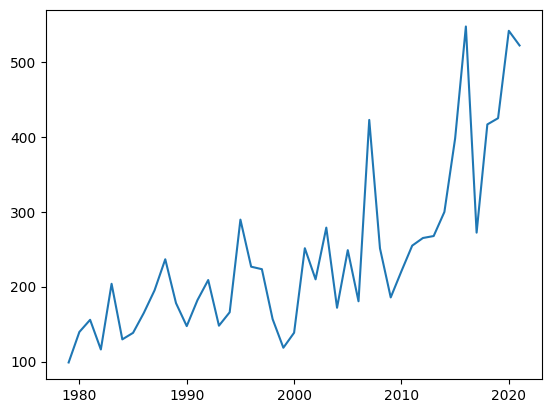

In [251]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



df = pd.read_csv(gov["commodity"], header=[0,1] ).dropna()


In [231]:
df = pd.read_csv(gov["commodity"], header=[0,1] ).dropna()


,Unit
5,1979
6,1980
7,1981
8,1982
9,1983
10,1984
11,1985
12,1986
13,1987
14,1988


Governance/commodity_production_value.csv


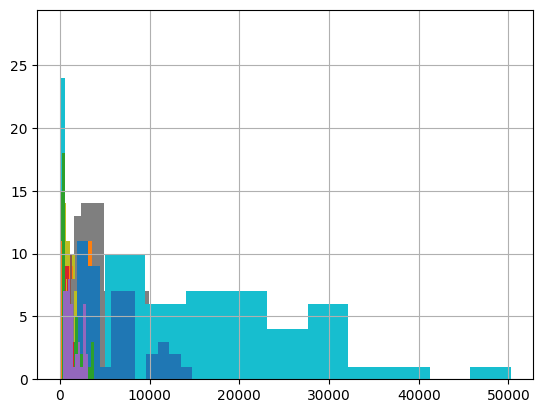

In [97]:
i =2
# print(gov[1])
# pd.read_csv(gov[1], header =0).dropna()

print(gov[2])
df = pd.read_csv(gov[2], header =[0,1]).dropna()
# print(df.columns[:])
from matplotlib import pyplot as plt
for name in df.columns[:]:
    # set name to the column name you want to plot

    df[name].hist()


In [393]:
df


,Region,Estimate,Estimate.1,Estimate.2,Estimate.3,Estimate.4,Estimate.5,Estimate.6,Estimate.7,Number of agricultural businesses,Number of agricultural businesses.1,Number of agricultural businesses.2,Number of agricultural businesses.3,Number of agricultural businesses.4,Number of agricultural businesses.5,Number of agricultural businesses.6,Number of agricultural businesses.7
Year,,,,,,,,,,,,,,,,,
2011,Adelaide-Central and HillsAdelaide-NorthAdelai...,1.216334e+09,4763390.40,2.701245e+07,3941942.20,7214483.00,251.60,6422604.50,2.701245e+07,406529.0,140158.0,358630.0,206996.0,100370.0,0.0,104462.0,358630.0
2012,Adelaide - Central and HillsAdelaide - NorthAd...,1.189786e+09,5567493.60,3.577841e+07,5267375.80,8813877.80,282.40,7133772.20,3.577841e+07,386460.0,147490.0,352536.0,188081.0,80713.0,0.0,91810.0,352536.0
2013,Adelaide - Central and HillsAdelaide - NorthAd...,1.218601e+09,6237231.74,3.465314e+07,5570452.56,8938912.45,249.85,7079633.27,3.216597e+07,384703.0,140019.0,343158.0,190422.0,76656.0,0.0,108094.0,108094.0
2014,Adelaide - Central and HillsAdelaide - NorthAd...,1.153581e+09,6321340.44,2.933087e+07,3490340.85,6215398.23,267.88,6446339.07,2.684571e+07,368891.0,143082.0,330192.0,178050.0,82523.0,0.0,109426.0,109426.0
2015,Adelaide - Central and HillsAdelaide - NorthAd...,1.113139e+09,7067016.13,2.746272e+07,2939508.02,7234229.37,285.80,6442228.18,2.513572e+07,256881.0,99846.0,232220.0,120307.0,58280.0,0.0,67972.0,67969.0
2016,Adelaide - Central and HillsAdelaide - NorthAd...,1.181314e+09,5442827.79,2.988915e+07,3970961.69,8696503.31,243.35,6705846.26,2.723600e+07,263635.0,101593.0,239289.0,125335.0,54560.0,0.0,65976.0,65976.0
2017,Adelaide - Central and HillsAdelaide - NorthAd...,1.134198e+09,6459122.78,3.146137e+07,3495661.64,9015624.81,266.00,6893000.97,2.919160e+07,256090.0,98921.0,232272.0,114704.0,50113.0,0.0,67181.0,67181.0
2018,Adelaide - Central and HillsAdelaide - NorthAd...,1.151231e+09,6815684.79,2.386633e+07,2277086.87,6039079.37,385.42,5860165.81,2.153697e+07,267665.0,105072.0,239390.0,117268.0,48685.0,0.0,65381.0,65381.0
2019,Adelaide - Central and HillsAdelaide - SouthAu...,1.130825e+09,6278399.75,1.934394e+07,1621729.19,4218599.71,247.92,4547032.95,1.689752e+07,262219.0,61720.0,145798.0,60576.0,28120.0,0.0,61399.0,61399.0


In [19]:
jidf.isna().sum()


TypeError: unsupported operand type(s) for +: 'int' and 'str'

Region                                  object
Estimate                               float64
Estimate.1                             float64
Estimate.2                             float64
Estimate.3                             float64
Estimate.4                             float64
Estimate.5                             float64
Estimate.6                             float64
Estimate.7                             float64
Number of agricultural businesses      float64
Number of agricultural businesses.1    float64
Number of agricultural businesses.2    float64
Number of agricultural businesses.3    float64
Number of agricultural businesses.4    float64
Number of agricultural businesses.5    float64
Number of agricultural businesses.6    float64
Number of agricultural businesses.7    float64
dtype: object
65647.79
Year
2011    4763390.40
2012    5567493.60
2013    6237231.74
2014    6321340.44
2015    7067016.13
2016    5442827.79
2017    6459122.78
2018    6815684.79
2019    6278399.75
20

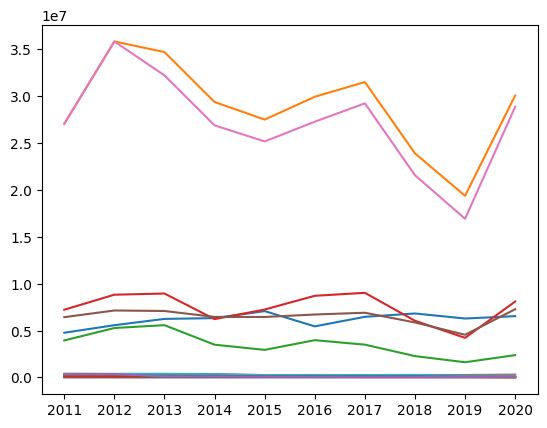

In [392]:
df = pd.read_csv(enviro_csv['water_usage'])
df = df.rename(columns={
    'Unnamed: 0':'Region',
    'Unnamed: 1':'Year',
})
df = df.dropna()
df.set_index(['Year'],inplace=True)
for column in df.columns:
    if column != 'Region':
        df[column] = pd.to_numeric(df[column], errors='coerce')
print(df.dtypes)

print(sum(map(lambda x:float(x),'11596.94	20319.02	6748.18	1136.24	2.85	6716.88	19127.68'.split())))
df = df.groupby('Year').sum()
for column in df.columns:
    if column not in( 'Region','Estimate'):
        print(df[column])
        plt.plot(df.index,df[column] ,label=column)
plt.show()


In [29]:
df.dtypes


Unnamed: 0                             object
Unnamed: 1                             object
Estimate                               object
Estimate.1                             object
Estimate.2                             object
Estimate.3                             object
Estimate.4                             object
Estimate.5                             object
Estimate.6                             object
Estimate.7                             object
Number of agricultural businesses      object
Number of agricultural businesses.1    object
Number of agricultural businesses.2    object
Number of agricultural businesses.3    object
Number of agricultural businesses.4    object
Number of agricultural businesses.5    object
Number of agricultural businesses.6    object
Number of agricultural businesses.7    object
dtype: object

In [13]:

import pandas as pd

# first row is header
lng_df = pd.read_csv('Governance/Copy of agriculture_australian_economy.csv', header=1)
lng_df.head()


,Activity 2,Percent change from previous period,Imports,Exports,Current account balance,Net foreign debt level,Net foreign debt share of GDP,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,Location,Australia,Australia,Australia,Australia,Australia,Australia,Australia,United States of America,European Union,Japan,Organisation for Economic Cooperation and Deve...,China,Republic of Korea
1,Measure,Rate,Value,Value,Value,Value,Rate,Rate,Rate,Rate,Rate,Rate,Rate,Rate
2,Unit,%,$m,$m,$m,$m,%,%,%,%,%,%,%,%
3,1974,1.30,"10,160.00","10,160.00",-959.00,NaN,NaN,1.76,-0.50,NaN,-1.20,0.49,2.30,9.40
4,1975,2.60,"11,253.00","11,253.00","-1,131.00","3,133.00",NaN,2.51,-0.20,NaN,3.10,0.18,8.70,7.30


In [52]:
import pandas as pd

pd.read_csv("Governance/agriculture_australian_economy.csv", header= [0,1,2])


FileNotFoundError: [Errno 2] No such file or directory: 'Governance/agriculture_australian_economy.csv'